https://www.kaggle.com/code/grishasizov/simple-denoising-diffusion-model-toy-1d-example/notebook#Is-the-noise-really-linear?

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F



In [9]:
x0 = -5  # "realistic" sample which the model needs to learn to generate
n_steps = 100  # number of denoising time steps



In [10]:
alphas = 1. - torch.linspace(0.001, 0.2, n_steps)
alphas_cumprod = torch.cumprod(alphas, axis=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - sqrt_alphas_cumprod ** 2)



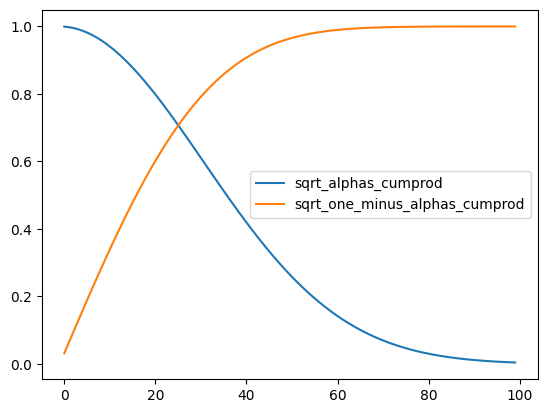

In [11]:
plt.plot(sqrt_alphas_cumprod, label="sqrt_alphas_cumprod")
plt.plot(sqrt_one_minus_alphas_cumprod, label="sqrt_one_minus_alphas_cumprod")
plt.legend()



In [12]:
def q_sample(x_0, t, noise):
    """
    Sample x at time t given the value of x at t=0 and the noise
    """
    return sqrt_alphas_cumprod.gather(-1, t) * x_0 + sqrt_one_minus_alphas_cumprod.gather(-1, t) * noise



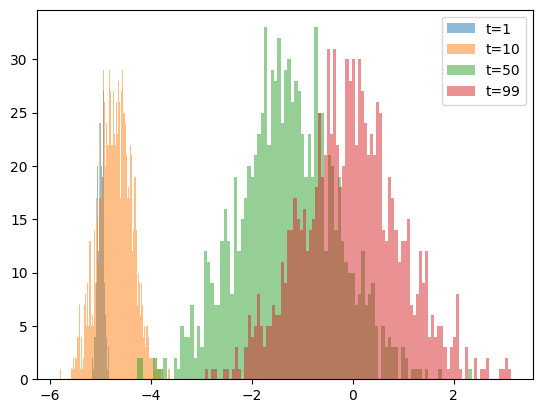

In [13]:
for t in [1, n_steps // 10, n_steps // 2, n_steps - 1]:
    noised_x = q_sample(x0, torch.tensor(t), torch.randn(1000))
    plt.hist(noised_x.numpy(), bins=100, alpha=0.5, label=f"t={t}");
plt.legend()



Text(0, 0.5, 'x')

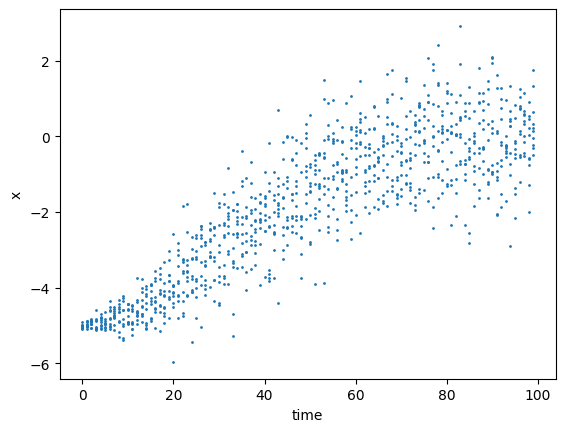

In [14]:
res = [(t, q_sample(x0, torch.tensor(t), torch.randn(1)).item()) for _ in range(10) for t in range(n_steps)]
x, y = list(zip(*res))
plt.scatter(x, y, s=1)
plt.xlabel("time")
plt.ylabel("x")



In [15]:
# instead using U-net we try to predict noise with a linear model \epsilon_t = ax_t + bt + c; a, b, c are trainable parameters

class DenoiseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Parameter(torch.tensor(1.))
        self.b = torch.nn.Parameter(torch.tensor(0.))
        self.c = torch.nn.Parameter(torch.tensor(0.))

    def forward(self, x, t):
        return self.a * x + self.b * t + self.c

In [16]:
def p_loss(x, t):
    # Generate a noise
    noise = torch.randn(t.shape)
    # Compute x at time t with this value of the noise - forward process
    noisy_x = q_sample(x, t, noise)
    # Use our trained model to predict the value of the noise, given x(t) and t
    noise_computed = denoise(noisy_x, t)
    # Compare predicted value of the noise with the actual value
    return F.mse_loss(noise, noise_computed)

In [17]:
denoise = DenoiseModel()
optimizer = torch.optim.Adam(denoise.parameters())

n_epochs = 10000
batch_size = 1000
for step in range(n_epochs):
    optimizer.zero_grad()
    t = torch.randint(0, n_steps, (batch_size, ))  # Pick random time step
    loss = p_loss(x0, t)
    loss.backward()
    if step % (n_epochs // 10) == 0:
        print(f"loss={loss.item():.4f}; a={denoise.a.item():.4f}, b={denoise.b.item():.4f}, c={denoise.c.item():.4f}")
    optimizer.step()
print(f"final: loss={loss.item():.4f}; a={denoise.a.item():.4f}, b={denoise.b.item():.4f}, c={denoise.c.item():.4f}")

loss=7.2009; a=1.0000, b=0.0000, c=0.0000
loss=0.8059; a=0.3565, b=-0.0056, c=0.6862
loss=0.6304; a=0.2859, b=-0.0113, c=0.9892
loss=0.5643; a=0.3443, b=-0.0149, c=1.3260
loss=0.5308; a=0.4281, b=-0.0209, c=1.7781
loss=0.4174; a=0.5252, b=-0.0273, c=2.3152
loss=0.3914; a=0.6280, b=-0.0346, c=2.8719
loss=0.2929; a=0.7170, b=-0.0410, c=3.3809
loss=0.3154; a=0.7904, b=-0.0457, c=3.7780
loss=0.3103; a=0.8371, b=-0.0488, c=4.0222
final: loss=0.3247; a=0.8576, b=-0.0505, c=4.1389


In [18]:
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = (1 - alphas) * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def p_sample(x, t):
    """
    One step of revese process sampling - Algorithm 2 from the paper
    """
    alpha_t = alphas.gather(-1, t)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.gather(-1, t)
    # Get mean x[t - 1] conditioned at x[t] - see eq. (11) in the paper
    model_mean = torch.sqrt(1.0 / alpha_t) * (x - (1 - alpha_t) * denoise(x, t) / sqrt_one_minus_alphas_cumprod_t)
    # Get variance of x[t - 1]
    model_var = posterior_variance.gather(-1, t)
    # Samples for the normal distribution with given mean and variance
    return model_mean + torch.sqrt(model_var) * torch.randn(1)

Text(0.5, 1.0, 'Reverse process - denoising')

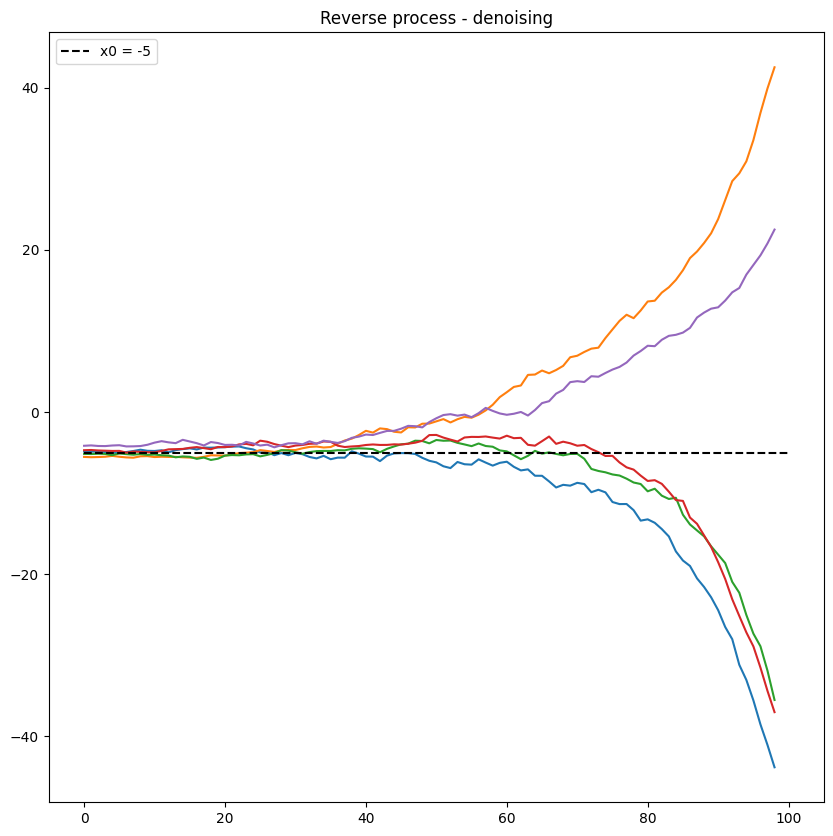

In [19]:
plt.figure(figsize=(10, 10))
for _ in range(5):
    x_gens = []
    x_gen = torch.randint(-50, 50, (1,))
    for i in range(n_steps - 1, 0, -1):
        x_gen = p_sample(x_gen, torch.tensor(i))
        x_gens.append(x_gen.detach().numpy()[0])
    plt.plot(x_gens[::-1])
plt.hlines(x0, 0, 100, color="black", linestyle="--", label=f"x0 = {x0}")
plt.legend(loc="upper left")
plt.title("Reverse process - denoising")

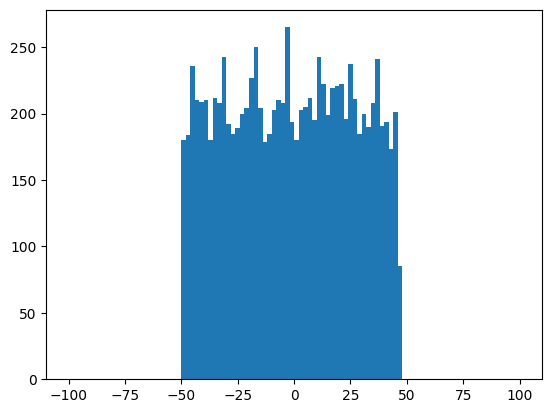

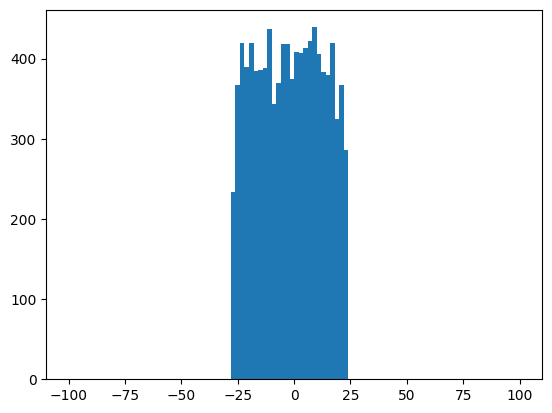

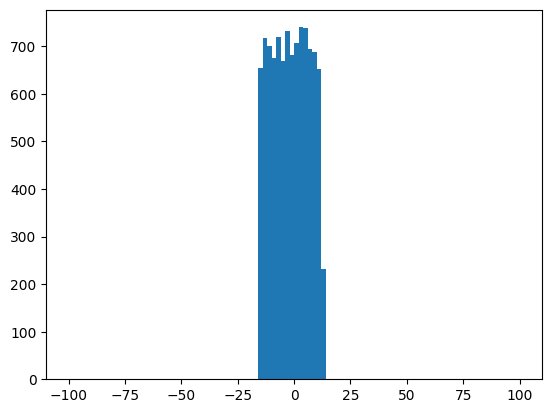

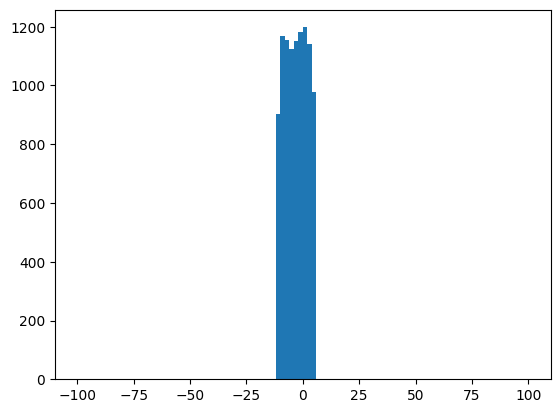

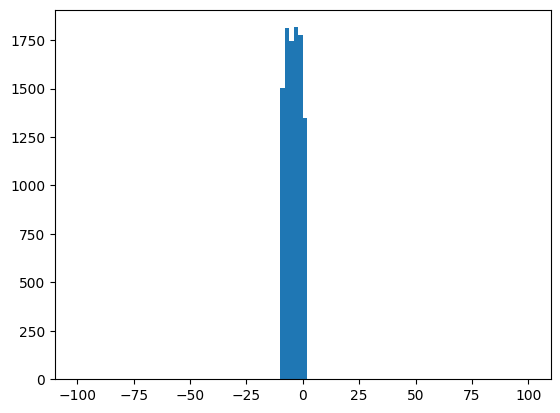

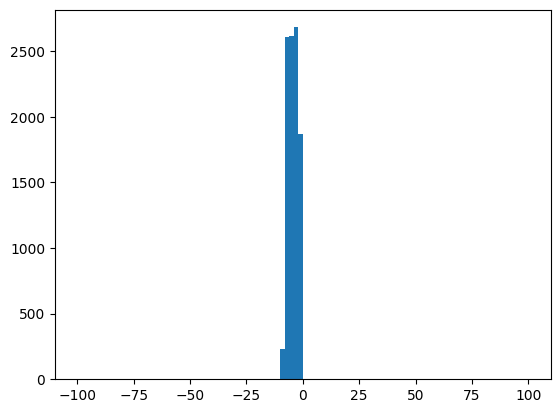

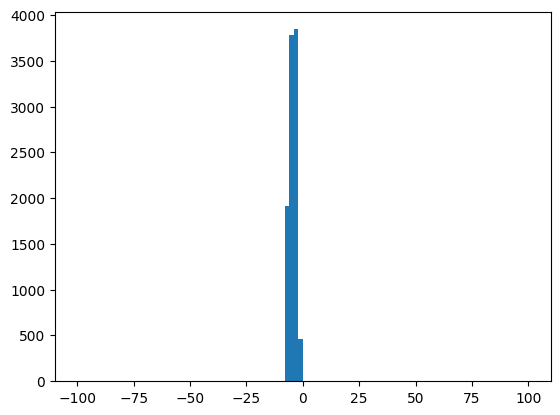

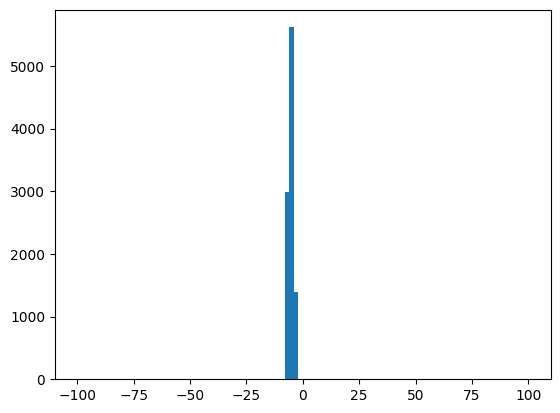

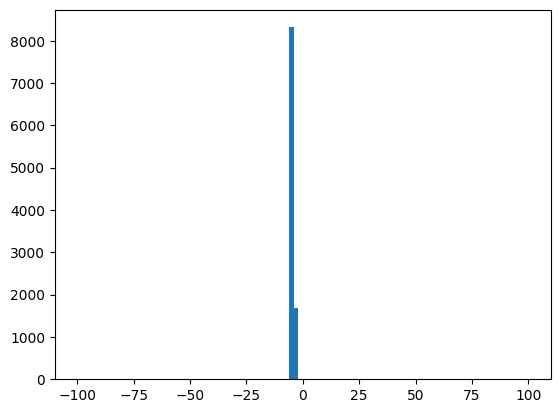

In [20]:
# Create a sample of 10000 "noisy" datapoint at time t = 100
x_gen = torch.randint(-100, 100, (10000,))
for i in range(n_steps - 1, 0, -1):
    # denoise the sample step by step backawards in time
    x_gen = p_sample(x_gen, torch.tensor(i))
    if i % 10 == 0:
        plt.hist(x_gen.detach().numpy(), range=(-100, 100), bins=100)
        plt.show()